In [1]:
import pandas as pd
import numpy as np
import os
import sys
from skforecast.ForecasterAutoreg import ForecasterAutoreg  ## fare riferimento alla documentazione di skforecast
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import time
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from skforecast.model_selection import grid_search_forecaster
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## COSTANTI

In [3]:
DATE_LIMITER = "2023-08-01 00:00:00"
TRAIN_SET_PERC = 0.8
LAGS = [96, 192, 288, 384, 480] # 1,2,3,4,5 giorni
STEPS = 4*6 # 12h

## FUNZIONI

In [4]:
def makePred(model, setToPredict ,lags, steps):
    i=0    
    lenVal = len(setToPredict)
    newPreds = []
    newTimes = []
    while(i + lags < lenVal):
        print(f"step {i+1}/{lenVal - lags}", end="\r")
        batch = setToPredict.iloc[i:i + lags]["Value"]
        betterPred = model.predict(steps , last_window=batch)
        newPreds.append(betterPred.iloc[-1])
        newTimes.append(betterPred.index[-1])
        i += 1
    pred = pd.Series(newPreds, newTimes)
    print("\n")
    return pred

In [5]:
def makePredMK2(model, setToPredict ,steps, lags = None): #mmmm
    if lags is None:
        lags = model.lags[len(model.lags)-1]

    lenVal = len(setToPredict)
    newPreds = []
    newTimes = []

    i=0
    while(i + lags < lenVal):
        print(f"step {i+1}/{lenVal - lags}", end="\r")
        batch = setToPredict.iloc[i:i + lags]["Value"]
        betterPred = model.predict(steps , last_window=batch)
        newPreds.append(betterPred.values)
        newTimes.append(betterPred.index)
        i += steps
    pred = pd.Series(newPreds, newTimes)
    print("\n")
    return pred

In [6]:
def printScore(realData, predictedData):
    real = realData.values
    pred = predictedData.values
    mape = mean_absolute_percentage_error(real, pred)
    r2 = r2_score(real, pred)

    info = f"___SCORE___\nmape: {mape:.5}\nr2: {r2:.5}"    
    ax.annotate(info, (predictedData.index[int(len(pred)*0.5)],50))    
    ax.fill_between(predictedData.index, pred+pred*mape, pred-pred*mape, color='C1', alpha=0.3)
    #output.write(f"\n___SCORE___\nmape: {mape:.5}\nr2: {r2:.5}\n")
    print(f"\n___SCORE___\nmape: {mape:.5}\nr2: {r2:.5}\n")

In [7]:
def makePred_predAsData(model, setToPredict, steps): # TO DO
    lags = model.lags[len(model.lags)-1]
    lenVal = len(setToPredict)
    i=0
    newPreds = []
    newTimes = []

    c = steps / 4
    r = steps % 4
    
    while(i + lags < lenVal):
        print(f"step {i+1}/{lenVal - lags}", end="\r")

        batch = setToPredict.iloc[i:i + lags]["Value"]
        j = 0
        while j < c:
            smolPred = model.predict(4 , last_window=batch)
            j += 1
            newPreds.append(smolPred.iloc[-1])
            ##
            print(smolPred)
            print(batch)
            return 
            ##
            batch.append(smolPred.iloc[-1])
            newTimes.append(smolPred.index[-1])
        if j == c and r != 0:
            smolPred = model.predict(j , last_window=batch)
            newPreds.append(smolPred.iloc[-1])
            batch.append(smolPred.iloc[-1])
            newTimes.append(smolPred.index[-1])
                   
        # newPreds.append(betterPred.iloc[-1])
        # newTimes.append(betterPred.index[-1])
        i += 1
        
    pred = pd.Series(newPreds, newTimes)
    print("\n")
    return pred

## DATI

In [8]:
PATH = os.path.dirname(os.path.abspath("__file__"))
PATH = os.path.join(PATH, "data", "trendLvSolignanoUlia.csv")

allData = pd.read_csv(PATH,delimiter=";")
allData.columns = ["Time", "Value"]
allData["Time"] = pd.to_datetime(allData["Time"])
allData.set_index("Time", inplace=True)
allData = allData.resample(rule="15T").mean().ffill()

In [9]:
stableData = allData[allData.index < DATE_LIMITER]

setDivisor = int(len(stableData) * TRAIN_SET_PERC)

trainingSet = stableData.iloc[:setDivisor]
validationSet = stableData.iloc[setDivisor:]


In [10]:
strangeData = allData[allData.index >= DATE_LIMITER]

#### DIVISIONE DI 30 MINUTI

In [8]:
allDataHalfH = allData.resample(rule="30T").mean().ffill()

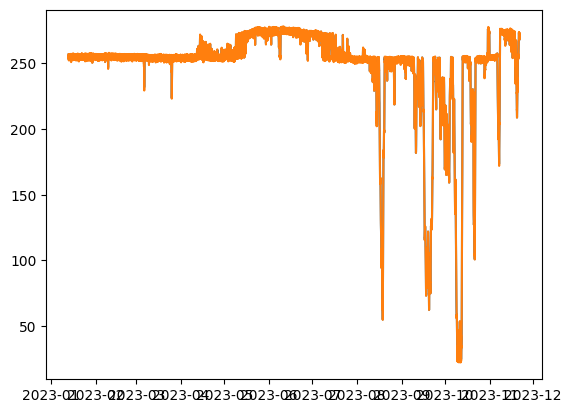

In [9]:
plt.plot(allDataHalfH)
plt.plot(allData)

#### DIVISIONE 1 GIORNO

In [24]:
allDataDay = allData.resample(rule="1d").mean().ffill()
allDataH = allData.resample(rule="1h").mean().ffill()

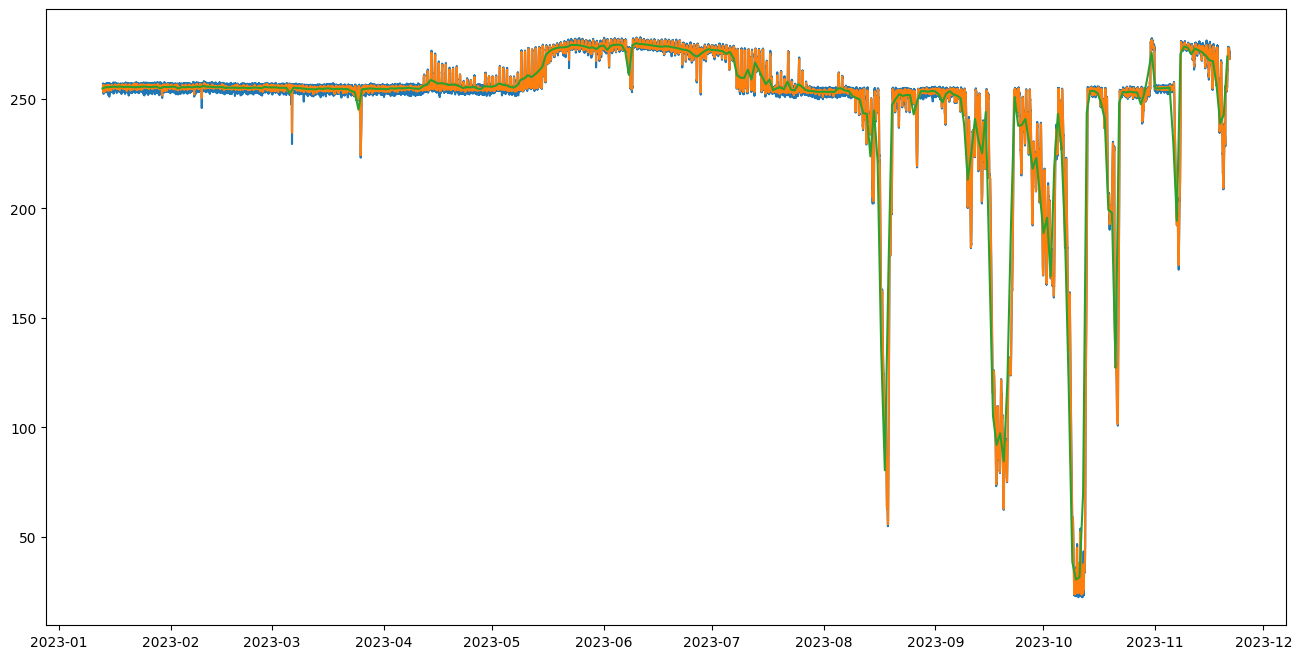

In [26]:
plt.subplots(figsize=(16,8))
plt.plot(allData)
plt.plot(allDataH)
plt.plot(allDataDay)

## TRAINING

In [74]:
xgb = XGBRegressor()
lags = LAGS[1]

model = ForecasterAutoreg(regressor=xgb, lags=lags)

model.fit(trainingSet["Value"])


### PREDIZIONI SUI SET

#### TRANING SET

In [91]:
start = time.time()
predVal = makePredMK2(model, trainingSet, 48)
end = time.time()
print(f"predizione sul Training set: {int(end-start)} s")

ValueError: Length of values (316) does not match length of index (48)


___SCORE___
mape: 0.0026488
r2: 0.97895



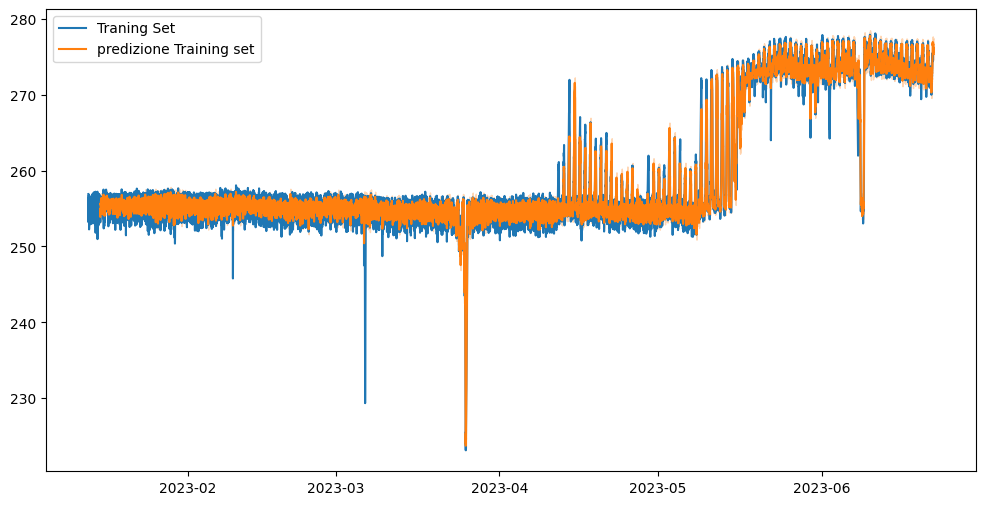

In [58]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(trainingSet, label="Traning Set")
ax.plot(predVal, label="predizione Training set")
printScore(allData.loc[predVal.index], predVal)
plt.legend()

#### VALIDATION SET

In [44]:
start = time.time()
predVal = makePred(model, validationSet, lags, STEPS)
end = time.time()
print(f"predizione sul validation set: {int(end-start)} s")

step 3741/3741

predizione sul validation set: 13 s



___SCORE___
mape: 0.0052383
r2: 0.94441



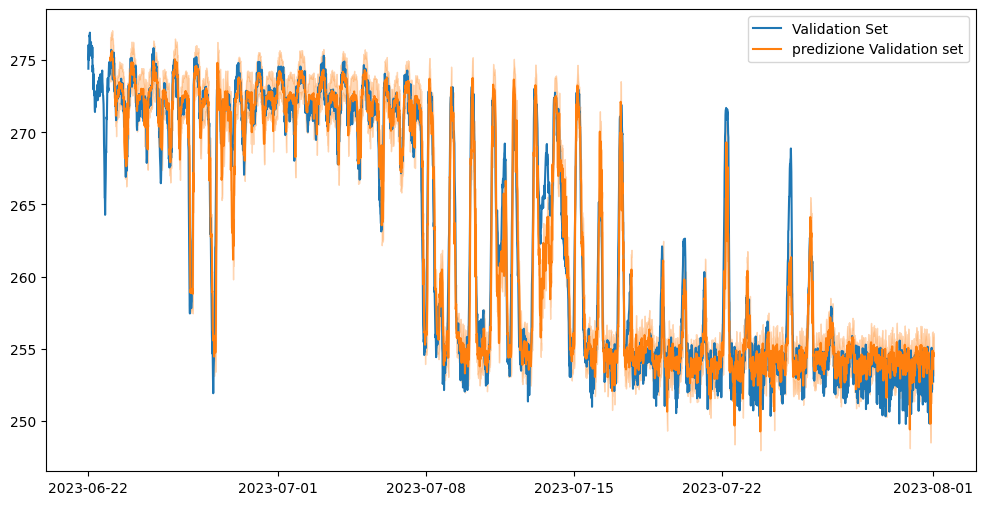

In [45]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(validationSet, label="Validation Set")
ax.plot(predVal, label="predizione Validation set")
printScore(allData.loc[predVal.index], predVal)
plt.legend()

#### STRANGE SET

In [46]:
start = time.time()
predVal = makePred(model, strangeData, lags, STEPS)
end = time.time()
print(f"predizione sul Strange set: {int(end-start)} s")

step 10721/10721

predizione sul Strange set: 35 s



___SCORE___
mape: 0.35444
r2: 0.11818



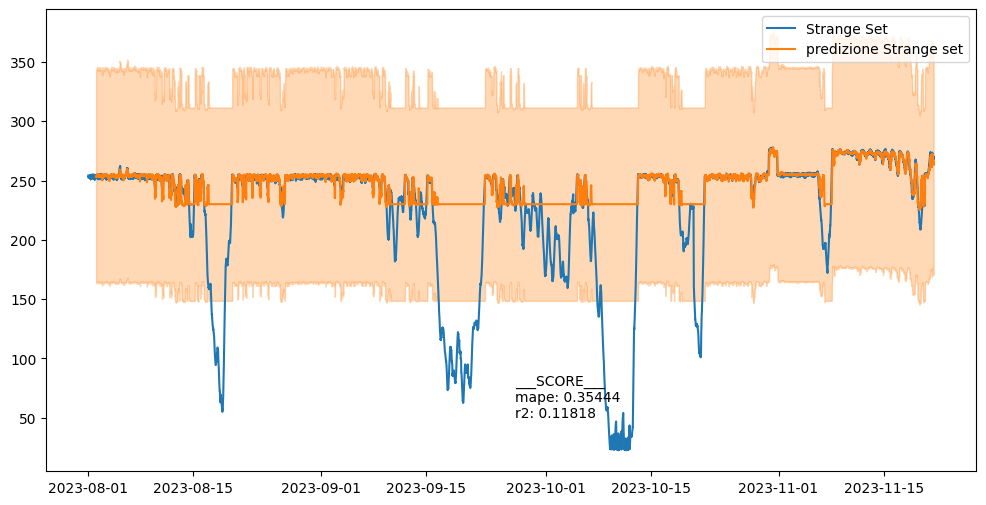

In [47]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(strangeData, label="Strange Set")
ax.plot(predVal, label="predizione Strange set")
printScore(allData.loc[predVal.iloc[:-STEPS+1].index], predVal.iloc[:-STEPS+1])
plt.legend()

## TUNING IPERPARAMETRI XGBRegressor

In [38]:
reg = XGBRegressor()

In [39]:
forecast = ForecasterAutoreg(reg, 48)

In [40]:
param_grid = {
    "max_depth": [7,8,9,10],
    "eta": [0.3, 0.1],
    "subsample": [0.25,0.50,0.75],
    "colsample_bytree": [0.25,0.50,0.75]
}

In [41]:
lags_grid = [96, 144, 192]

**!LA CELLA SEGUENTE IMPIEGA PIÙ DI 30 MINUTI!**

In [42]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = stableData["Value"],
    param_grid  = param_grid,
    lags_grid   = lags_grid,
    steps       = 4*12,
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(stableData)*TRAIN_SET_PERC),
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 216.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/72 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96] 
  Parameters: {'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 7, 'subsample': 0.75}
  Backtesting metric: 0.00834982375767028



,lags,params,mean_absolute_percentage_error,colsample_bytree,eta,max_depth,subsample
38,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008350,0.50,0.1,7.0,0.75
41,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008350,0.50,0.1,8.0,0.75
189,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008362,0.50,0.1,10.0,0.25
188,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008397,0.50,0.1,9.0,0.75
44,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008446,0.50,0.1,9.0,0.75
...,...,...,...,...,...,...,...
48,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.75, 'eta': 0.3, 'max_de...",0.012012,0.75,0.3,7.0,0.25
99,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.3, 'max_dep...",0.012164,0.50,0.3,8.0,0.25
201,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.75, 'eta': 0.3, 'max_de...",0.012397,0.75,0.3,10.0,0.25
195,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.75, 'eta': 0.3, 'max_de...",0.013519,0.75,0.3,8.0,0.25


In [43]:
Fxgb = forecast

In [48]:
start = time.time()
predVal = makePred(Fxgb, validationSet, lags_grid[2], 48)
end = time.time()
print(f"predizione sul Strange set: {int(end-start)} s")

step 3645/3645

predizione sul Strange set: 87 s



___SCORE___
mape: 0.0076427
r2: 0.80854



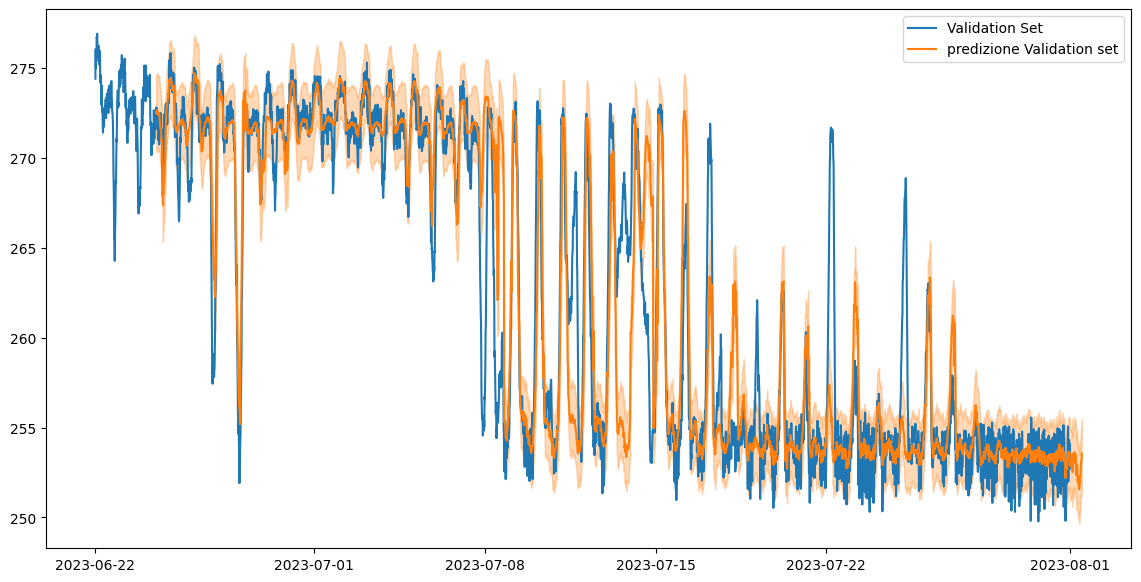

In [49]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(validationSet, label="Validation Set")
ax.plot(predVal, label="predizione Validation set")
printScore(allData.loc[predVal.index], predVal)
plt.legend()

In [27]:
forecast = ForecasterAutoreg(XGBRegressor(colsample_bytree=0.5, eta=0.1, subsample=0.75), 48)
param_gridOK = {
    "max_depth": [7,8,9,10] 
}
# param_gridOK = {}
lags_grid = [48,96,144,192,240,288]

## Future Step 1 ora

In [10]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = stableData["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(stableData)*TRAIN_SET_PERC), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 24.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

,lags,params,mean_absolute_percentage_error,max_depth
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 7},0.004001,7
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 8},0.004030,8
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 7},0.004043,7
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 9},0.004063,9
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 9},0.004083,9
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 8},0.004084,8
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 7},0.004138,7
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.004163,10
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.004179,10
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 8},0.004193,8


In [11]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = stableData["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(stableData)*0.5), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 24.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

,lags,params,mean_absolute_percentage_error,max_depth
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.024884,10
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 7},0.025135,7
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.025445,10
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 8},0.025854,8
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.026763,10
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 9},0.026948,9
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 8},0.027312,8
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 9},0.028146,9
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 8},0.028508,8
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 7},0.028610,7


In [70]:
modelFsOne = ForecasterAutoreg(XGBRegressor(colsample_bytree=0.5, eta=0.1, max_depth=10, subsample=0.75), lags_grid[1])##CACAO
modelFsOne.fit(trainingSet["Value"])

In [85]:
start = time.time()
predVal = makePred_predAsData(modelFsOne, strangeData, 4) #CACAO
end = time.time()
print(f"predizione sul Strange set: {int(end-start)} s")

step 10721/10721

predizione sul Strange set: 32 s


In [87]:
predVal

2023-08-02 00:45:00    253.163757
2023-08-02 01:00:00    252.637436
2023-08-02 01:15:00    252.761917
2023-08-02 01:30:00    252.916779
2023-08-02 01:45:00    252.814987
                          ...    
2023-11-21 15:45:00    264.007050
2023-11-21 16:00:00    262.848175
2023-11-21 16:15:00    264.281342
2023-11-21 16:30:00    263.868927
2023-11-21 16:45:00    263.731079
Length: 10721, dtype: float64


___SCORE___
mape: 0.36679
r2: 0.053102



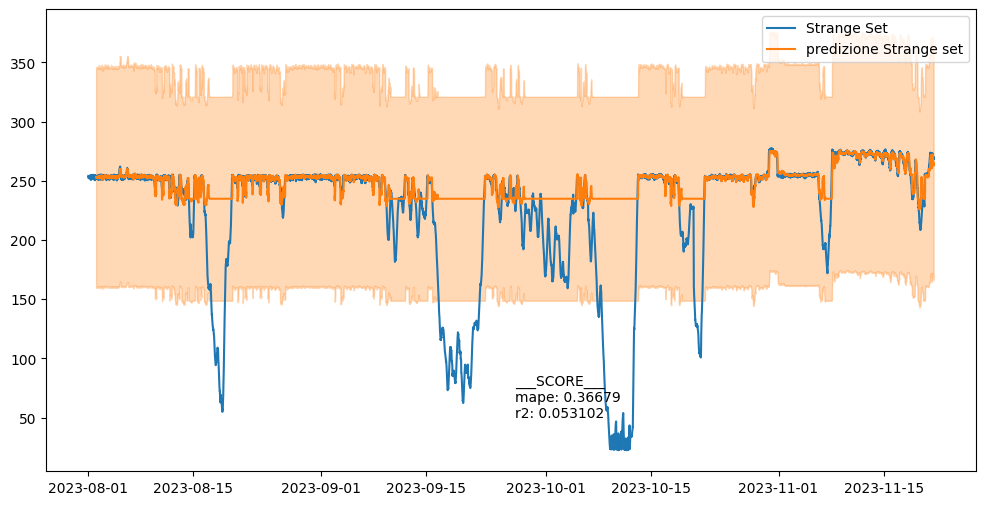

In [86]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(strangeData, label="Strange Set")
ax.plot(predVal, label="predizione Strange set")
printScore(allData.loc[predVal.iloc[:-4+1].index], predVal.iloc[:-4+1])
plt.legend()

## Future Step 6 ore

In [51]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = stableData["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*6, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(stableData)*TRAIN_SET_PERC), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 24.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96] 
  Parameters: {'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 7, 'subsample': 0.75}
  Backtesting metric: 0.007711382053205362



,lags,params,mean_absolute_percentage_error,colsample_bytree,eta,max_depth,subsample
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.007711,0.5,0.1,7.0,0.75
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.007725,0.5,0.1,8.0,0.75
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.007738,0.5,0.1,9.0,0.75
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.007808,0.5,0.1,9.0,0.75
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.007831,0.5,0.1,7.0,0.75
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.007915,0.5,0.1,8.0,0.75
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.007919,0.5,0.1,10.0,0.75
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.007939,0.5,0.1,10.0,0.75
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.007979,0.5,0.1,9.0,0.75
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008004,0.5,0.1,7.0,0.75


In [52]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = stableData["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*6, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(stableData)*0.5), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 24.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96] 
  Parameters: {'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 8, 'subsample': 0.75}
  Backtesting metric: 0.033233283478977686



,lags,params,mean_absolute_percentage_error,colsample_bytree,eta,max_depth,subsample
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.033233,0.5,0.1,8.0,0.75
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.033260,0.5,0.1,7.0,0.75
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.034078,0.5,0.1,8.0,0.75
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.034796,0.5,0.1,10.0,0.75
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.035378,0.5,0.1,7.0,0.75
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.035455,0.5,0.1,8.0,0.75
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.035473,0.5,0.1,9.0,0.75
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.035566,0.5,0.1,10.0,0.75
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.035951,0.5,0.1,9.0,0.75
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.036227,0.5,0.1,7.0,0.75


In [62]:
modelFsSix = ForecasterAutoreg(XGBRegressor(colsample_bytree=0.5, eta=0.1, max_depth=8, subsample=0.75), lags_grid[1])
modelFsSix.fit(trainingSet["Value"])

In [63]:
start = time.time()
predVal = makePred(modelFsSix, strangeData, lags_grid[1], 24)
end = time.time()
print(f"predizione sul Strange set: {int(end-start)} s")

step 10721/10721

predizione sul Strange set: 125 s



___SCORE___
mape: 0.37585
r2: 0.035705



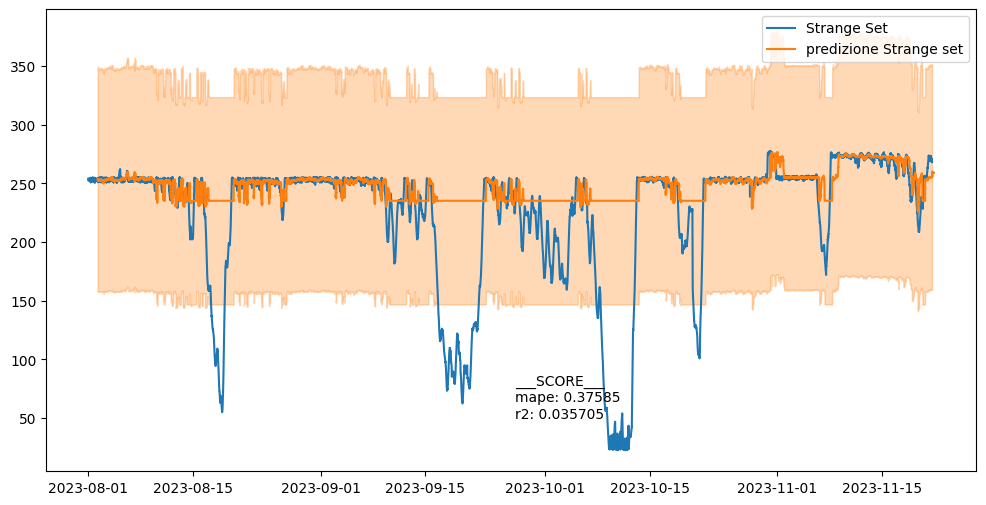

In [64]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(strangeData, label="Strange Set")
ax.plot(predVal, label="predizione Strange set")
printScore(allData.loc[predVal.iloc[:-24+1].index], predVal.iloc[:-24+1])
plt.legend()

**si noti che l'errore molto elevato è soprattuto causato dai picchi anomali**

## Future Step 12 ore

In [65]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = stableData["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*12, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(stableData)*0.8), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 24.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96] 
  Parameters: {'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 7, 'subsample': 0.75}
  Backtesting metric: 0.00834982375767028



,lags,params,mean_absolute_percentage_error,colsample_bytree,eta,max_depth,subsample
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008350,0.5,0.1,7.0,0.75
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008350,0.5,0.1,8.0,0.75
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008397,0.5,0.1,9.0,0.75
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008446,0.5,0.1,9.0,0.75
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008596,0.5,0.1,7.0,0.75
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008702,0.5,0.1,7.0,0.75
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008718,0.5,0.1,10.0,0.75
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008732,0.5,0.1,8.0,0.75
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008796,0.5,0.1,10.0,0.75
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.008797,0.5,0.1,8.0,0.75


In [66]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = stableData["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*12, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(stableData)*0.5), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 24.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96] 
  Parameters: {'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 8, 'subsample': 0.75}
  Backtesting metric: 0.03429490996143319



,lags,params,mean_absolute_percentage_error,colsample_bytree,eta,max_depth,subsample
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.034295,0.5,0.1,8.0,0.75
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.034519,0.5,0.1,8.0,0.75
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.034685,0.5,0.1,7.0,0.75
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.036012,0.5,0.1,10.0,0.75
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.036122,0.5,0.1,7.0,0.75
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.036152,0.5,0.1,8.0,0.75
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.036237,0.5,0.1,9.0,0.75
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.036270,0.5,0.1,9.0,0.75
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.036829,0.5,0.1,7.0,0.75
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.036919,0.5,0.1,10.0,0.75


In [81]:
modelFsTwe = ForecasterAutoreg(XGBRegressor(colsample_bytree=0.5, eta=0.1, max_depth=8, subsample=0.75), lags_grid[1])
modelFsTwe.fit(trainingSet["Value"])

In [82]:
start = time.time()
predVal = makePred(modelFsTwe, strangeData, lags_grid[1], 48)
end = time.time()
print(f"predizione sul Strange set: {int(end-start)} s")

step 10721/10721

predizione sul Strange set: 244 s



___SCORE___
mape: 0.38012
r2: 0.023957



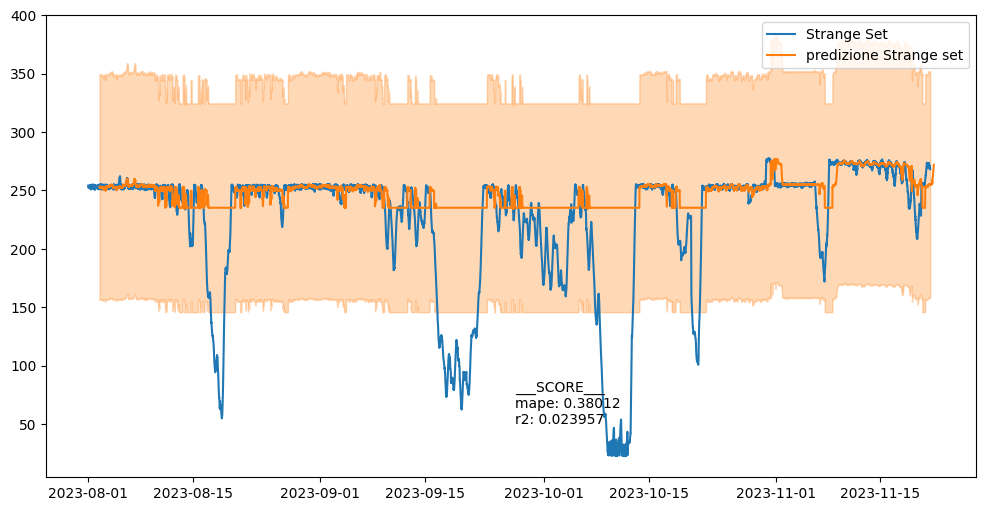

In [83]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(strangeData, label="Strange Set")
ax.plot(predVal, label="predizione Strange set")
printScore(allData.loc[predVal.iloc[:-48+1].index], predVal.iloc[:-48+1])
plt.legend()

## Future Step 24 ore

In [84]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = stableData["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*24, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(stableData)*0.8), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 24.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96] 
  Parameters: {'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 8, 'subsample': 0.75}
  Backtesting metric: 0.010154137995560442



,lags,params,mean_absolute_percentage_error,colsample_bytree,eta,max_depth,subsample
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.010154,0.5,0.1,8.0,0.75
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.010164,0.5,0.1,9.0,0.75
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.010197,0.5,0.1,7.0,0.75
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.010216,0.5,0.1,8.0,0.75
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.010249,0.5,0.1,9.0,0.75
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.010250,0.5,0.1,10.0,0.75
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.010279,0.5,0.1,7.0,0.75
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.010308,0.5,0.1,8.0,0.75
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.010350,0.5,0.1,10.0,0.75
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.010394,0.5,0.1,7.0,0.75


In [117]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = stableData["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*24, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(stableData)*0.5), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 24.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144] 
  Parameters: {'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 8, 'subsample': 0.75}
  Backtesting metric: 0.034398956774267214



,lags,params,mean_absolute_percentage_error,colsample_bytree,eta,max_depth,subsample
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.034399,0.5,0.1,8.0,0.75
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.034499,0.5,0.1,8.0,0.75
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.034892,0.5,0.1,7.0,0.75
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.034977,0.5,0.1,10.0,0.75
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.034996,0.5,0.1,8.0,0.75
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.035191,0.5,0.1,10.0,0.75
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.035205,0.5,0.1,9.0,0.75
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.035779,0.5,0.1,7.0,0.75
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.036010,0.5,0.1,9.0,0.75
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.5, 'eta': 0.1, 'max_dep...",0.036044,0.5,0.1,9.0,0.75


In [118]:
modelFsTF = ForecasterAutoreg(XGBRegressor(colsample_bytree=0.5, eta=0.1, max_depth=8, subsample=0.75), lags_grid[1])
modelFsTF.fit(trainingSet["Value"])

In [119]:
start = time.time()
predVal = makePred(modelFsTF, strangeData, lags_grid[1], 96)
end = time.time()
print(f"predizione sul Strange set: {int(end-start)} s")

step 10721/10721

predizione sul Strange set: 489 s



___SCORE___
mape: 0.3826
r2: 0.016422



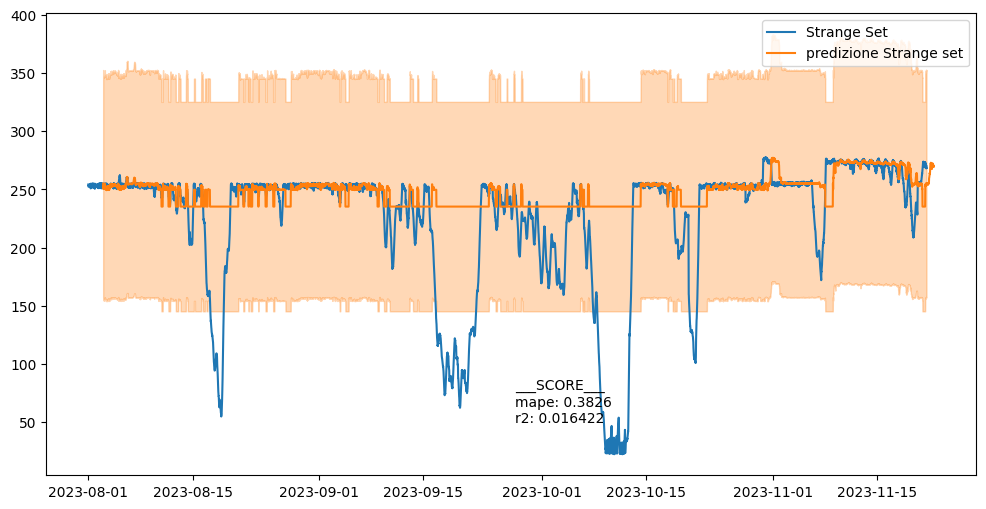

In [120]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(strangeData, label="Strange Set")
ax.plot(predVal, label="predizione Strange set")
printScore(allData.loc[predVal.iloc[:-96+1].index], predVal.iloc[:-96+1])
plt.legend()

In [ ]:
modelFsTF_2 = ForecasterAutoreg(XGBRegressor(colsample_bytree=0.5, eta=0.1, max_depth=8, subsample=0.75), lags_grid[2])
modelFsTF_2.fit(trainingSet["Value"])
start = time.time()
%%time
predVal = makePred(modelFsTF_2, strangeData, lags_grid[2], 96)
end = time.time()
print(f"predizione sul Strange set: {int(end-start)} s")

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(strangeData, label="Strange Set")
ax.plot(predVal, label="predizione Strange set")
printScore(allData.loc[predVal.iloc[:-96+1].index], predVal.iloc[:-96+1])
plt.legend()

## Future Step 48 ore

In [28]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = stableData["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*48, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(stableData)*0.8), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 24.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

,lags,params,mean_absolute_percentage_error,max_depth
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 9},0.011578,9
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 7},0.011629,7
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 9},0.011656,9
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 7},0.011733,7
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 8},0.012010,8
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 8},0.012073,8
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 7},0.012123,7
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 9},0.012162,9
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.012229,10
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.012236,10


In [29]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = stableData["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*48, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(stableData)*0.5), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 24.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144] 
  Parameters: {'max_depth': 8}
  Backtesting metric: 0.03553187429029061



,lags,params,mean_absolute_percentage_error,max_depth
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 8},0.035532,8
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.036049,10
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.036118,10
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 9},0.036222,9
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 9},0.036424,9
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 7},0.036601,7
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 7},0.036602,7
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 8},0.036670,8
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 8},0.036915,8
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 9},0.038088,9


In [37]:
modelFsFE = ForecasterAutoreg(XGBRegressor(colsample_bytree=0.5, eta=0.1, max_depth=9, subsample=0.75), lags_grid[5]) # CACAO
modelFsFE.fit(trainingSet["Value"])

In [58]:
start = time.time()
predVal = makePred(modelFsFE, strangeData, lags_grid[5], 192) # CACAO
end = time.time()
print(f"predizione sul Strange set: {int(end-start)} s")

step 10529/10529

predizione sul Strange set: 966 s



___SCORE___
mape: 0.39929
r2: -0.0098956



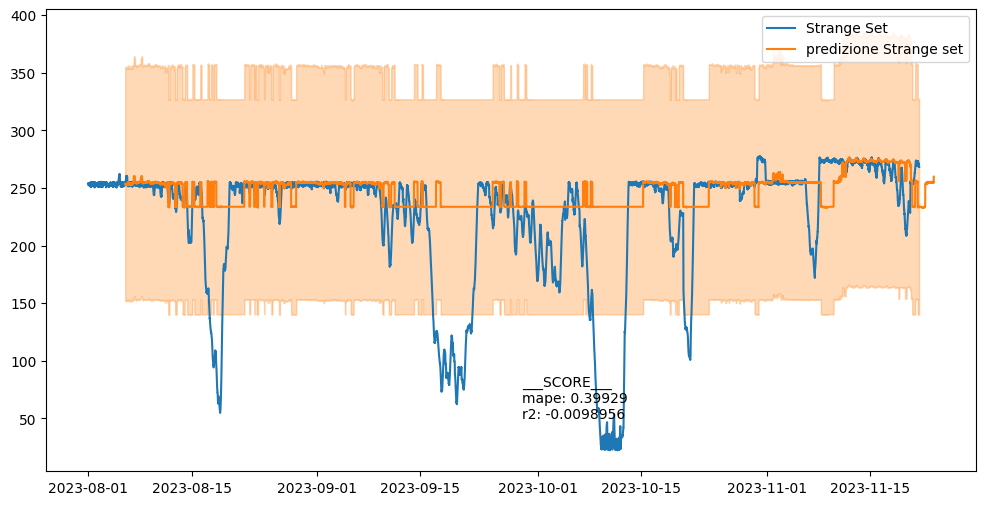

In [59]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(strangeData, label="Strange Set")
ax.plot(predVal, label="predizione Strange set")
printScore(allData.loc[predVal.iloc[:-192].index], predVal.iloc[:-192])
plt.legend()

**Sembra che con l'avvicinarsi di lags a steps, il modello faccia previsioni non solo meno dettagliate, ma anche "shiftate", Peggiori**

aumentiamo lags

In [53]:
start = time.time()
predVal = makePred(modelFsFE, strangeData, 288, 12) #DIFF
end = time.time()
print(f"predizione sul Strange set: {int(end-start)} s")

step 10529/10529

predizione sul Strange set: 79 s



___SCORE___
mape: 0.37497
r2: 0.05972



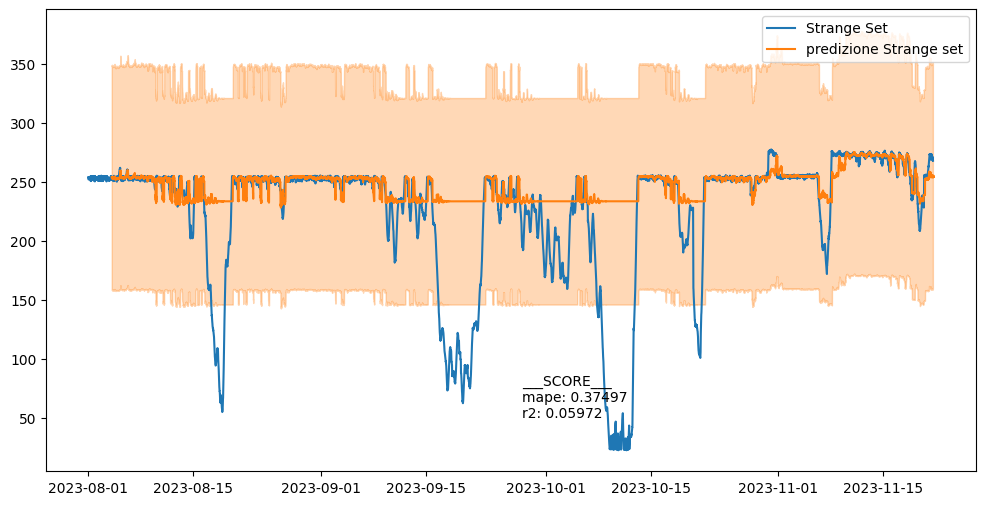

In [56]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(strangeData, label="Strange Set")
ax.plot(predVal, label="predizione Strange set")
printScore(allData.loc[predVal.iloc[:-12].index], predVal.iloc[:-12])
plt.legend()

peggiorata la situa

**immagino la difficoltà derivi dall'estrema variabilità del dato nell'arco di una singola giornata**

vorrei provare nelle previsioni, ad esempioda 4*12, a dividerle e fare una previsione da 4 ed usare la previsione per fare la previsione successiva, teoricamente dovrebbe già fare così ma sinceramente non mi sembra **<- ci ho messo 3 ore a capire che non ha senso**, poco per lo meno, noi stiamo misurando l'accuratezza solo dell'ultimo rilevamento, ad es con step = 48 (12 ore) salviamo solo la 48esima previsione e ignoriamo tutte le altre

## TUNING IPERPARAMETRI KernelRidge

In [11]:
kr = KernelRidge()
Fkr = ForecasterAutoreg(kr, 192)

In [12]:
KR_param_grid = {
    "alpha": [0.005, 0.01, 0.02]
}
KR_lags_grid = [48, 92, 144, 192, 240]

In [13]:
res = grid_search_forecaster(
    forecaster  = Fkr,
    y           = stableData["Value"],
    param_grid  = KR_param_grid,
    lags_grid   = KR_lags_grid,
    steps       = 4*12,
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(stableData)*0.8),
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 15.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

,lags,params,mean_absolute_percentage_error,alpha
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.005},0.008181,0.005
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},0.008182,0.010
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.02},0.008182,0.020
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},0.008271,0.010
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.02},0.008271,0.020
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.005},0.008272,0.005
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.005},0.008370,0.005
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},0.008370,0.010
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.02},0.008370,0.020
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.02},0.008810,0.020


In [ ]:
start = time.time() # LENTISSIMO WTH
predVal = makePred(Fkr, trainingSet, 240, 48)
end = time.time()
print(f"predizione sul Training set: {int(end-start)} s")

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(trainingSet, label="Traning Set")
ax.plot(predVal, label="predizione Training set")
printScore(allData.loc[predVal.index], predVal)
plt.legend()

## PROVE

Text(2023-09-26 08:00:00, 50, '___SCORE___\nmape: 0.1\nr2: 0.1')

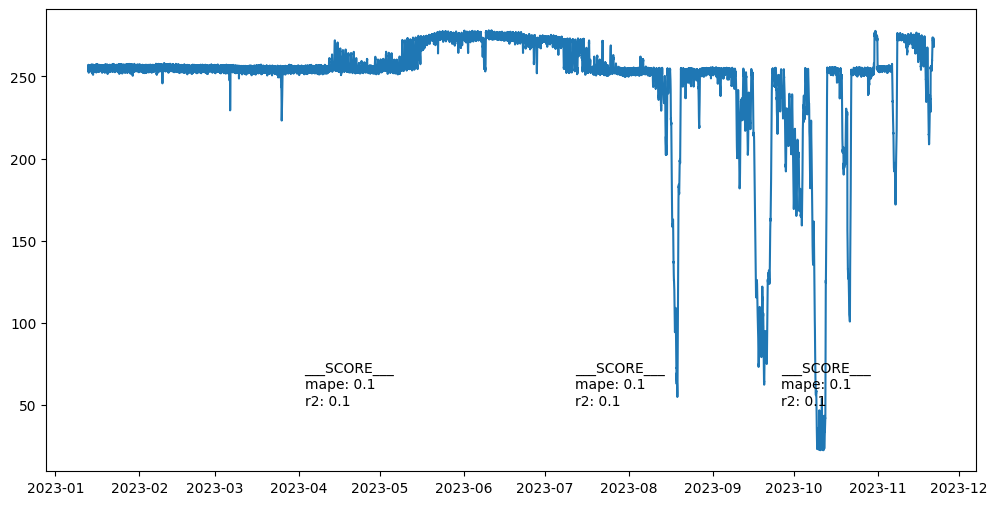

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
info = f"___SCORE___\nmape: 0.1\nr2: 0.1"
ax.plot(allData)
ax.annotate(info, (trainingSet.index[int(len(trainingSet)*0.5)],50))
ax.annotate(info, (validationSet.index[int(len(validationSet)*0.5)],50))
ax.annotate(info, (strangeData.index[int(len(strangeData)*0.5)],50))

In [180]:
from datetime import datetime

In [229]:
datetime.now().strftime("%d/%m/%Y %H:%M:%S")

'27/11/2023 16:47:19'

In [10]:
np.logspace(-2,2, 5)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [71]:
modelFsTwe.lags = list(range(1,4))
modelFsTwe.lags

[1, 2, 3]

In [106]:
a = pd.Series(list(range(0,11)))
b = pd.Series(list(range(2,13)))
a
b

0      2
1      3
2      4
3      5
4      6
5      7
6      8
7      9
8     10
9     11
10    12
dtype: int64

In [104]:
a.iloc[2:]

2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
dtype: int64

In [107]:
b.iloc[:-2]

0     2
1     3
2     4
3     5
4     6
5     7
6     8
7     9
8    10
dtype: int64

In [114]:
%time a.values.sum()


CPU times: total: 0 ns
Wall time: 0 ns


55

In [116]:
%time sum(a)

CPU times: total: 0 ns
Wall time: 0 ns


55

In [29]:
forecast.get_feature_importances

<bound method ForecasterAutoreg.get_feature_importances of ================= 
ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37 

In [32]:
forecast.lags[len(forecast.lags)-1]

288

In [52]:
a = pd.Series([1,2,3])
a

0    1
1    2
2    3
dtype: int64

In [55]:
a += 4
a

0     9
1    10
2    11
dtype: int64

In [58]:
a.append(pd.Series([4]))

0     9
1    10
2    11
0     4
dtype: int64

In [77]:
forecast.lags[len(forecast.lags)-1]

288

In [79]:
modelFsOne.lags[len(modelFsOne.lags)-1]

96

In [92]:
int(9/4)

2

In [93]:
9%4

1

In [94]:
c = 12

0
1
2
3
4
5
6
7
8
9
10
11


In [13]:
lags = 192
steps=12
lenVal = len(validationSet)

newPreds = []
newTimes = []

c = steps / 4
r = steps % 4

# i=0
# while(i + lags < lenVal):
#     print(f"step {i+1}/{lenVal - lags}", end="\r")

j=0
while j < c:
    batch = validationSet.iloc[i:i + lags]["Value"]
    betterPred = model.predict(4 , last_window=batch)
    print(betterPred)
    j+=1

        
#     newPreds.append(betterPred.iloc[-1])
#     newTimes.append(betterPred.index[-1])
    # i += 1
        
# pred = pd.Series(newPreds, newTimes)
print("\n")

2023-07-17 16:30:00    259.903198
2023-07-17 16:45:00    258.896515
2023-07-17 17:00:00    259.062317
2023-07-17 17:15:00    258.571014
Freq: 15T, Name: pred, dtype: float64
2023-07-17 16:30:00    259.903198
2023-07-17 16:45:00    258.896515
2023-07-17 17:00:00    259.062317
2023-07-17 17:15:00    258.571014
Freq: 15T, Name: pred, dtype: float64
2023-07-17 16:30:00    259.903198
2023-07-17 16:45:00    258.896515
2023-07-17 17:00:00    259.062317
2023-07-17 17:15:00    258.571014
Freq: 15T, Name: pred, dtype: float64




In [67]:
a = [pd.Series(), []]
a

[Series([], dtype: float64), []]

In [68]:
a.append([[1,2,3],["ah","ne","so"]])

In [69]:
a.

[Series([], dtype: float64), [], [[1, 2, 3], ['ah', 'ne', 'so']]]